## Use ip_isr Task to make brighter-fatter kernel from a set of high-intensity flats.
Michael Wood-Vasey  (2018-08-21)

With substantial help from Merlin Fisher-Levine.

Jim Chiang kindly created a set of Phosim and ImSim flats at NERSC:

* ImSim flat pairs are `/global/cscratch1/sd/jchiang8/desc/imsim_tests/bf_flats/lsst_a_*r.fits`
  - ImSim visits are 161899, 161900
  - Gains are set to 1.7
* PhoSim flat pairs are `/global/cscratch1/sd/jchiang8/desc/calibration_products/bf_flats/lsst_a*.fits`.  
  - The visit numbers for these PhoSim flat pairs are 0..11.
  - Gains are set to 1.0.
  - There are three pairs in u at 70k, 80k, and 90k e-/pixel, and three pairs in i for the same signal levels.   Note that these are in the _ImSim_ `raw` format since the original PhoSim runs didn't generate the amplifier files, so it's not trivially easy to make PhoSim `raw` format images.  

Use `lsst.obs.lsstCam.ImsimMapper` for both on ingest.

Jim also made a set of ImSim flat pairs for R22_S11 for a sequence of signal levels, from 10k to 80k e-/pixel, in steps of 10k.  One might use these in the future to look at the full photon transfer curve ("non-linearity").  
`/global/cscratch1/sd/jchiang8/desc/imsim_tests/bf_flats/ptc_dataset/lsst_a*.fits`  
These pairs can be identified by looking for the shorter `EXPTIME` values.

### Logistics

* Versions  
This was run through the JupyterLab environment at NERSC (https://jupyter-dev.nersc.gov) based on `w_2018_26`
but with a custom kernelspec that loaded a set of local checkouts of

```
obs_base tickets/DM-13293
obs_lsstCam tickets/DM-15509
cp_pipe tickets/DM-13293
```

file:///global/homes/w/wmwv/.local/share/jupyter/kernels/desc-stack-obs-lsstCam  
file:/global/homes/w/wmwv/.local/share/jupyter/kernels/desc-stack-obs-lsstCam/kernel.json  
file:/global/homes/w/wmwv/.local/share/jupyter/kernels/desc-stack-obs-lsstCam/desc-stack-obs-lsstCam.sh

* Hacks
  - Because I was basing this off of `w_2018_26`, I additionally had to
    * comment-out the `exposure.setWcs` command in the raw assembly in `obs_lsstCam`.
    * Define a warpper `run` method in `makeBrighterFatterTask.py` that calls `runDataRef`.
  - The `cp_pipe` tickets/DM-13293 is still under review and currently has a dependency on `eotest` in the default set of things that get loaded when loading the `cp_pipe` module.  I manually commented out
  ```
  #     from .cpTask import *
  ```
  in the `cp_pipe/python/lsst/cp/pipe/__init__.py` file.

## References
* For an introduction to the brighter-fatter effect, see 
  - http://adsabs.harvard.edu/abs/2014JInst...9C3048A  Antilogous, Astier, Guyonnet, Regnault. 2014. JInst, 9, C3048.
* For a starting place for DESC thinking about brighter-fatter, see 
  - https://confluence.slac.stanford.edu/display/LSSTDESC/Brighter+Fatter+Effect   (DESC private page)
* See Andrew Bradshaw's [StackClub](https://github.com/LSSTScienceCollaborations/StackClub) notebook studying the brighter-fatter effect on stars and galaxies projected from the lab-based beam simulator.
  - [Rendered] http://nbviewer.jupyter.org/url/andrewnomy.com/sync/BrighterFatterCorrection.ipynb?flush_cache=true
  - [Raw] https://github.com/LSSTScienceCollaborations/StackClub/blob/project/beamsim/andrewkbradshaw/ImageProcessing/BrighterFatterCorrection.ipynb
* Analysis of Brighter-Fatter in DECam
  - http://adsabs.harvard.edu/abs/2015JInst..10C5032G  Gruen, Berstein, JArvis, Rowe, Vikram, Plazas, Seitz.  2015.  JInst, 10, C5032.

In [145]:
import numpy as np
import matplotlib.pyplot as plt

In [146]:
# Test to make sure that we can import obs_lsstCam
import lsst.obs.base
import lsst.obs.lsstCam

In [147]:
from lsst.cp.pipe.makeBrighterFatterKernel import MakeBrighterFatterKernelTask
from lsst.daf.persistence import Butler
from lsst.pipe.tasks.ingest import IngestTask

## Make PhoSim Brighter-Fatter Kernel

In [148]:
# Uncomment this `rm` command when you really mean to reingest, reprocess, and delete repo
! rm -rf phosim_repo

! mkdir phosim_repo
! echo "lsst.obs.lsstCam.LsstCamMapper" > phosim_repo/_mapper

# Ingest the PhoSim flats
! ingestImages.py phosim_repo /global/cscratch1/sd/jchiang8/desc/calibration_products/bf_flats/lsst_a*.fits --mode link

root INFO: Loading config overrride file '/global/homes/w/wmwv/local/lsst/obs_lsstCam/config/ingest.py'
LsstCamMapper WARN: Unable to find calib root directory
CameraMapper INFO: Loading Posix exposure registry from /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/phosim_repo
ingest INFO: /global/cscratch1/sd/jchiang8/desc/calibration_products/bf_flats/lsst_a_000000_R22_S11.fits --<link>--> /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/phosim_repo/raw/0/R22/00000000-R22-S11-det094-000.fits
ingest INFO: /global/cscratch1/sd/jchiang8/desc/calibration_products/bf_flats/lsst_a_000001_R22_S11.fits --<link>--> /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/phosim_repo/raw/1/R22/00000001-R22-S11-det094-000.fits
ingest INFO: /global/cscratch1/sd/jchiang8/desc/calibration_products/bf_flats/lsst_a_000002_R22_S11.fits --<link>--> /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/phosim_repo/raw/2/R22/00000002-R22-S11-det094-000.fits
ingest INFO: /global/cscratch1/sd/jchian

In [152]:
# Make up some gain values
# This is clearly wrong.
amp_names = ['C{:02d}'.format(i) for i in range(18)]
phosim_gain = 1.0
nominalGain = {a: phosim_gain for a in amp_names}

In [153]:
butler = Butler('phosim_repo')

gain = nominalGain
dataRef = butler.dataRef('brighterFatterGain', dataId={'detector': phosim_detector}) 
dataRef.put(gain, 'brighterFatterGain')   

Calculate the brighter-fatter kernel using `MakeBrighterFatterKernelTask`.  This will take ~10 minutes.

In [151]:
args = ['phosim_repo', '--rerun', 'test',
        '--id', 'detector={}'.format(phosim_detector),
        '--visit-pairs', '3,9', '4,8', '6,7',
        '-c',
        'xcorrCheckRejectLevel=2', 'doCalcGains=False',
        '--clobber-config', '--clobber-versions'
       ]

# In case you want to compare with running in terminal.
# Or perhaps you have access more easily to the stack version in a terminal than in a Jupyter kernel:
command_line = 'makeBrighterFatterKernel.py ' + ' '.join(args)
print(command_line)

phosim_pb_struct = MakeBrighterFatterKernelTask.parseAndRun(args=args)

makeBrighterFatterKernel.py phosim_repo --rerun test --id detector=94 --visit-pairs 1,5 3,9 4,8 10,2 0,11 6,7 -c xcorrCheckRejectLevel=2 doCalcGains=False --clobber-config --clobber-versions


Ignore warnings.

It worked.  let's load in the kernel and look at it!

In [154]:
phosim_detector = 94
test_butler = Butler('calib_repo/rerun/test')
phosim_bf_kernel = test_butler.get('brighterFatterKernelNew', dataId={'raftName': 'R22', 'detectorName': 'S11', 'detector': phosim_detector})

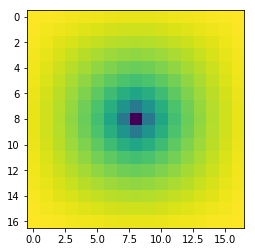

In [155]:
plt.imshow(phosim_bf_kernel[phosim_detector])

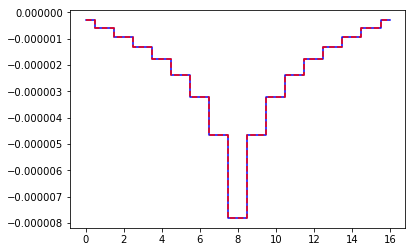

In [158]:
plt.plot(phosim_bf_kernel[phosim_detector][:,8], color='blue', drawstyle='steps-mid')
plt.plot(phosim_bf_kernel[phosim_detector][8,:], linestyle='--', color='red', drawstyle='steps-mid')

## Make ImSim Brighter-Fatter Kernel

In [159]:
# Uncomment this `rm` command when you really mean to reingest, reprocess, and delete repo
! rm -rf imsim_repo

! mkdir imsim_repo
! echo "lsst.obs.lsstCam.LsstCamMapper" > imsim_repo/_mapper

# Ingest the PhoSim flats
! ingestImages.py imsim_repo /global/cscratch1/sd/jchiang8/desc/imsim_tests/bf_flats/lsst_a_*r.fits --mode link

root INFO: Loading config overrride file '/global/homes/w/wmwv/local/lsst/obs_lsstCam/config/ingest.py'
LsstCamMapper WARN: Unable to find calib root directory
CameraMapper INFO: Loading Posix exposure registry from /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/imsim_repo
ingest INFO: /global/cscratch1/sd/jchiang8/desc/imsim_tests/bf_flats/lsst_a_161899_R01_S00_r.fits --<link>--> /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/imsim_repo/raw/161899/R01/00161899-R01-S00-det000-000.fits
ingest INFO: /global/cscratch1/sd/jchiang8/desc/imsim_tests/bf_flats/lsst_a_161899_R01_S01_r.fits --<link>--> /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/imsim_repo/raw/161899/R01/00161899-R01-S01-det001-000.fits
ingest INFO: /global/cscratch1/sd/jchiang8/desc/imsim_tests/bf_flats/lsst_a_161899_R01_S02_r.fits --<link>--> /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/imsim_repo/raw/161899/R01/00161899-R01-S02-det002-000.fits
ingest INFO: /global/cscratch1/sd/jchiang8/desc/im

In [160]:
# Explicitly set the gain values.
amp_names = ['C{:02d}'.format(i) for i in range(18)]
imsim_gain = 1.7
nominalGain = {a: imsim_gain for a in amp_names}

In [161]:
butler = Butler('imsim_repo')

imsim_detectors = (0, 1, 2, 3)

gain = nominalGain
for det in imsim_detectors:
    dataRef = butler.dataRef('brighterFatterGain', dataId={'detector': det}) 
    dataRef.put(gain, 'brighterFatterGain')   

In [125]:
args = ['imsim_repo', '--rerun', 'test',
        '--id', 'detector=0..3',
        '--visit-pairs', '161899,161900',
        '-c',
        'xcorrCheckRejectLevel=2', 'doCalcGains=False',
        '--clobber-config', '--clobber-versions'
       ]

# In case you want to compare with running in terminal.
# Or perhaps you have access more easily to the stack version in a terminal than in a Jupyter kernel:
command_line = 'makeBrighterFatterKernel.py ' + ' '.join(args)
print(command_line)

imsim_pb_struct = MakeBrighterFatterKernelTask.parseAndRun(args=args)

makeBrighterFatterKernel.py imsim_repo --rerun test --id detector=0..3 --visit-pairs 161899,161900 -c xcorrCheckRejectLevel=2 doCalcGains=False --clobber-config --clobber-versions


In [126]:
test_butler = Butler('imsim_repo/rerun/test')

imsim_detectors = (0, 1, 2, 3)

imsim_bf_kernel = {}
for det in imsim_detectors:
    this_bf_kernel = test_butler.get('brighterFatterKernelNew', dataId={'detector': det})
    imsim_bf_kernel.update(this_bf_kernel)

In [127]:
print(imsim_bf_kernel.keys())

dict_keys([0, 1, 2, 3])


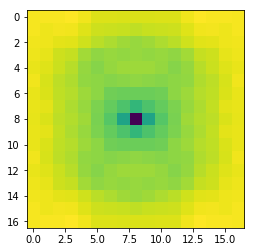

In [162]:
plt.imshow(imsim_bf_kernel[0])
plt.imshow(imsim_bf_kernel[1])
plt.imshow(imsim_bf_kernel[2])
plt.imshow(imsim_bf_kernel[3])

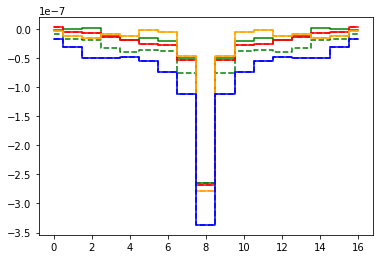

In [129]:
plt.plot(imsim_bf_kernel[0][:,8], color='green', drawstyle='steps-mid')
plt.plot(imsim_bf_kernel[0][8,:], color='green', linestyle='--', drawstyle='steps-mid')

plt.plot(imsim_bf_kernel[1][:,8], color='red', drawstyle='steps-mid')
plt.plot(imsim_bf_kernel[1][:,8], color='red', linestyle='--', drawstyle='steps-mid')

plt.plot(imsim_bf_kernel[2][:,8], color='orange', drawstyle='steps-mid')
plt.plot(imsim_bf_kernel[2][:,8], color='orange', linestyle='--', drawstyle='steps-mid')

plt.plot(imsim_bf_kernel[3][:,8], color='blue', drawstyle='steps-mid')
plt.plot(imsim_bf_kernel[3][:,8], color='blue', linestyle='--', drawstyle='steps-mid')

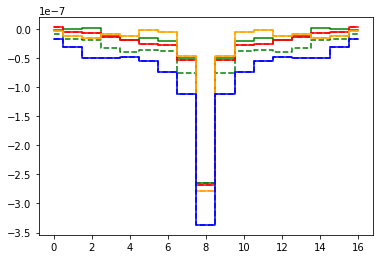

In [129]:
plt.plot(imsim_bf_kernel[0][:,8], color='green', drawstyle='steps-mid')
plt.plot(imsim_bf_kernel[0][8,:], color='green', linestyle='--', drawstyle='steps-mid')

plt.plot(imsim_bf_kernel[1][:,8], color='red', drawstyle='steps-mid')
plt.plot(imsim_bf_kernel[1][:,8], color='red', linestyle='--', drawstyle='steps-mid')

plt.plot(imsim_bf_kernel[2][:,8], color='orange', drawstyle='steps-mid')
plt.plot(imsim_bf_kernel[2][:,8], color='orange', linestyle='--', drawstyle='steps-mid')

plt.plot(imsim_bf_kernel[3][:,8], color='blue', drawstyle='steps-mid')
plt.plot(imsim_bf_kernel[3][:,8], color='blue', linestyle='--', drawstyle='steps-mid')

In [312]:
imsim_detector = 0  # We have 4.  Let's use this one when comparing below.

## HSC Brighter-Fatter Kernel
Calculated by Merlin Fisher-Levine

This is the brighter-fatter kernel for CCD 41.  The HSC BF corrections were done based purely on the results from this CCD.

In [296]:
hsc_detector = 41
# hsc_bf_kernel_file = 'hsc_bfKernel-{:03d}.pkl'.format(hsc_detector)
hsc_bf_kernel_file = 'hsc_brighter_fatter_kernel.pkl'
import pickle
with open(hsc_bf_kernel_file, 'rb') as f:
    hsc_bf_kernel = pickle.load(f, encoding='bytes')

# For the generic HSC BF kernel, stuff it into a dictionary so it looks like the other ones
hsc_bf_kernel = {hsc_detector: hsc_bf_kernel}

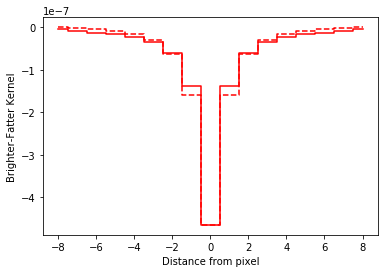

In [297]:
hsc_bf_radius = len(hsc_bf_kernel[hsc_detector])//2
r = np.arange(-hsc_bf_radius, +hsc_bf_radius+1)
plt.plot(r, hsc_bf_kernel[hsc_detector][:,hsc_bf_radius], color='red', drawstyle='steps-mid', label='HSC CCD 41 x')
plt.plot(r, hsc_bf_kernel[hsc_detector][hsc_bf_radius,:], color='red', linestyle='--', drawstyle='steps-mid', label='HSC CCD 41 y')
plt.xlabel('Distance from pixel')
plt.ylabel('Brighter-Fatter Kernel')

## Lab-based BF measurements

Let's compare this to lab-based ITL data from Craige Lage and Andrew Bradshaw.  I've taken the liberty of copying into this `DC2-production` repo the BF kernel they calculated from flats in the lab.

In [316]:
from astropy.io import fits
lab_bf_kernel = fits.getdata('BF_kernel-ITL_3800C_002.fits')
# Make it look like the other ones
lab_detector = 2
lab_bf_kernel = {lab_detector: lab_bf_kernel}

In [332]:
# Create some dicts to simplify code below
ref_detectors = {'PhoSim': phosim_detector, 'ImSim': imsim_detector, 'HSC': hsc_detector, 'ITL': lab_detector}
bf_kernels = {'PhoSim': phosim_bf_kernel, 'ImSim': imsim_bf_kernel, 'HSC': hsc_bf_kernel, 'ITL': lab_bf_kernel}
colors = {'PhoSim': 'blue', 'ImSim': 'green', 'HSC': 'red', 'ITL': 'orange'}

In [333]:
bf_centers = {k: len(bf_kernel[k][ref_detector[k]])//2 for k in bf_kernel}

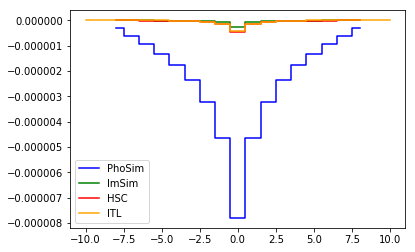

In [340]:
for k, bf in bf_kernel.items():
    r = np.arange(-bf_centers[k], +bf_centers[k]+1)
    kernel_row = bf_kernels[k][ref_detectors[k]][:, bf_centers[k]]
    plt.plot(r, kernel_row,
             drawstyle='steps-mid', color=colors[k], label='{}'.format(k))

plt.legend()

Hmmmm... are these just multiplicatively scaled versions?

Let's normalize to the central pixel.

In [337]:
central_values = {k: bf_kernel[k][ref_detector[k]][bf_center[k], bf_center[k]] for k in bf_kernel}
ref_scale = 'ITL'
scale = {k: central_values[ref_scale]/central_values[k] for k in central_values}

# phosim_scale, imsim_scale, hsc_scale, lab_scale = 0.055, 1.6, 0.92, 1

In [351]:
print(central_values)
print(scale)

{'PhoSim': -7.8050967195314527e-06, 'ImSim': -2.6468218297577638e-07, 'HSC': -4.6531742334076819e-07, 'ITL': -4.2391528333512312e-07}
{'PhoSim': 0.05431262399020869, 'ImSim': 1.6016011299631743, 'HSC': 0.91102387761800008, 'ITL': 1.0}


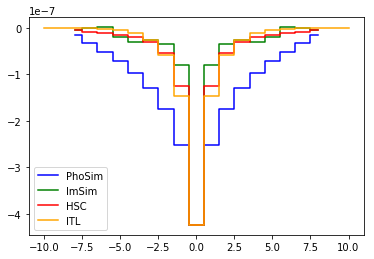

In [344]:
for k, bf in bf_kernel.items():
    r = np.arange(-bf_centers[k], +bf_centers[k]+1)
    kernel_row = bf_kernels[k][ref_detectors[k]][:, bf_centers[k]]
    plt.plot(r, scale[k] * kernel_row,
             drawstyle='steps-mid', color=colors[k], label='{}'.format(k))

plt.legend()

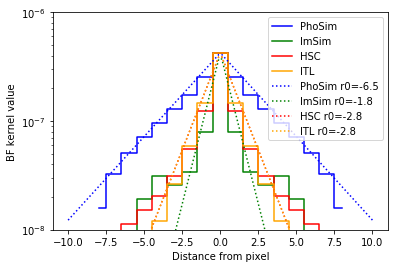

In [361]:
for k, bf in bf_kernel.items():
    r = np.arange(-bf_centers[k], +bf_centers[k]+1)
    kernel_row = bf_kernels[k][ref_detectors[k]][:, bf_centers[k]]
    plt.plot(r, - scale[k] * kernel_row,
             drawstyle='steps-mid', color=colors[k], label='{}'.format(k))

A = -central_values[ref_scale]
r0 = {'PhoSim': -6.5, 'ImSim': -1.8, 'HSC': -2.8, 'ITL': -2.8}
distance = np.linspace(-bf_centers[ref_scale], +bf_centers[ref_scale], 100)
for k, r in r0.items():
    plt.plot(distance, A*10**(-np.abs(distance/r)),
             color=colors[k], linestyle=':',
             label='{} r0={:.1f}'.format(k, r))

plt.ylim(1e-8, 1e-6)
plt.yscale('log')

plt.xlabel('Distance from pixel')
plt.ylabel('BF kernel value')

plt.legend()

------
### Things to think about running sometime in the future

In [ ]:
from lsst.pipe.drivers.constructCalibs import BiasTask
args_line = 'phosim_repo --rerun wmwv/calib --longlog --id visit=9999 --batch-type none --cores 4'
args = args_line.split(' ')
print(args)

### We're not actually going ton construct master bias or darks yet.
# BiasTask.parseAndSubmit(args=args)

In [ ]:
# ! constructBias.py calib_repo --rerun wmwv/calib --longlog --id visit=9999 --batch-type none --cores 4

root INFO: Loading config overrride file '/global/homes/w/wmwv/local/lsst/obs_lsstCam/config/bias.py'
LsstCamMapper WARN: Unable to find calib root directory
CameraMapper INFO: Loading exposure registry from /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/calib_repo/registry.sqlite3
LsstCamMapper WARN: Unable to find calib root directory
root INFO: Loading config overrride file '/global/homes/w/wmwv/local/lsst/obs_lsstCam/config/bias.py'
LsstCamMapper WARN: Unable to find calib root directory
CameraMapper INFO: Loading exposure registry from /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/calib_repo/registry.sqlite3
LsstCamMapper WARN: Unable to find calib root directory
INFO  2018-08-22T11:13:07.007 root ()(cmdLineTask.py:572)- Running: /global/common/software/lsst/cori-haswell-gcc/stack/w.2018.26_sim2.9.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/pipe_drivers/16.0+4/bin/constructBias.py calib_repo --rerun wmwv/calib --longlog --id visit=9999
WARN  2018-08-22T11:13:09.009 Ls

In [ ]:

## We don't have any master calibration images yet.
# ingestCalibs.py calib_repo --output calib_repo/CALIB --validity 13000 calib_repo/rerun/wmwv/calib/bias/2022-01-01/*.fits

# Darks next, before flats.
! ingestImages.py calib_repo dark_files/*.fits --mode link

# Make a master dark
! constructDark.py calib_repo --rerun wmwv/calib_dark --longlog --id visit=4000000 --batch-type none --cores 4

# Take the master dark we just created and load it into the CALIB_ROOT.
! ingestCalibs.py calib_repo --output calib_repo/CALIB --validity 13000 calib_repo/rerun/wmwv/calib_dark/dark/1994-07-19/*.fits

# Make a master flat.
! constructFlat.py calib_repo --rerun wmwv/calib_flat --longlog --id visit=219976 raft=R34 ccd=S02 --batch-type none

In [ ]:
imsim_raw_glob = '/global/cscratch1/sd/jchiang8/desc/imsim_tests/bf_flats/lsst_a_*r.fits'
phosim_raw_glob = '/global/cscratch1/sd/jchiang8/desc/calibration_products/bf_flats/lsst_a*.fits'

mapper_str = 'lsst.obs.lsstCam.ImsimMapper'

Ingest the calibration files.

In [4]:
from lsst.pipe.tasks.ingest import IngestTask

# Do biases first since constructDark.py expects them.
arg_string = 'calib_repo /global/cscratch1/sd/jchiang8/desc/calibration_products/bias_files/*.fits --mode link'
args = ' '.split(arg_string)

# But this doesn't actually work because IngestImages only uses sys.argv.
# It doesn't accept an args passthrough to the `parseAndRun` method.
# IngestTask.parseAndRun(args=args)

In [5]:
# So we call out to the shell with a !
### we don't even need bias or dark just to test out generation of the BF kernel.
# ! ingestImages.py calib_repo /global/cscratch1/sd/jchiang8/desc/calibration_products/bias_files/*.fits --mode link
# ! ingestImages.py calib_repo /global/cscratch1/sd/jchiang8/desc/calibration_products/dark_files/*.fits --mode link
! ingestImages.py calib_repo /global/cscratch1/sd/jchiang8/desc/calibration_products/bf_flats/lsst_a*.fits --mode link

root INFO: Loading config overrride file '/global/homes/w/wmwv/local/lsst/obs_lsstCam/config/ingest.py'
LsstCamMapper WARN: Unable to find calib root directory
CameraMapper INFO: Loading Posix exposure registry from /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/calib_repo
ingest INFO: /global/cscratch1/sd/jchiang8/desc/calibration_products/bf_flats/lsst_a_000000_R22_S11.fits --<link>--> /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/calib_repo/raw/0/R22/00000000-R22-S11-det094-000.fits
ingest INFO: /global/cscratch1/sd/jchiang8/desc/calibration_products/bf_flats/lsst_a_000001_R22_S11.fits --<link>--> /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/calib_repo/raw/1/R22/00000001-R22-S11-det094-000.fits
ingest INFO: /global/cscratch1/sd/jchiang8/desc/calibration_products/bf_flats/lsst_a_000002_R22_S11.fits --<link>--> /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/calib_repo/raw/2/R22/00000002-R22-S11-det094-000.fits
ingest INFO: /global/cscratch1/sd/jchiang8/d